<a href="https://colab.research.google.com/github/e-paj/M2M_Tech/blob/main/Capstone_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import graphviz
import sklearn
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

sklearn.set_config(display='diagram')
output_notebook()

## Data

### Data Description

* The dataset consists of a longitudinal MRI data of 150 subjects aged 60 to 96.

* Each subject was scanned at least once.

* Everyone is right-handed.

* 72 of the subjects were grouped as 'Nondemented' throughout the study.

* 64 of the subjects were grouped as 'Demented' at the time of their initial visits and remained so throughout the study, with 51 individuals having mild to moderate Alzheimer's disease.

* 14 subjects were grouped as 'Nondemented' at the time of their initial visit and were subsequently characterized as 'Demented' at a later visit.


### Column Descriptors

Subject ID: Subject Identification

MRI ID: MRI Exam Identification

Group: Class, either 'Demented', 'Nondemented', or 'Other'

Visit: Order of visit

MR Delay: MR Delay Time (Contrast)

M/F: Gender of patient

Hand: left-handed or right-handed

Age: range from 60-98

EDUC: Years of Education

SES: Socioeconomic Status

MMSE: Mini Mental State Examination

CDR: Clinical Dementia Rating

eTIV: Estimated Total Intracranial Volume

nWBV: Normalize Whole Brain Volume

ASF: Atlas Scaling Factor

In [ ]:
df = pd.read_csv('oasis_longitudinal.csv')
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


## Exploratory Data Analysis

To ensure any randomness throughout the code will be consistent.

In [ ]:
np.random.seed(10)

In [ ]:
df = df.loc[df['Visit']==1] # use first visit only because of the analysis

df = df.reset_index(drop=True)

df['M/F'] = df['M/F'].replace(['F','M'],[0,1])

df['Group'] = df['Group'].replace(['Converted'],['Demented'])

df['Group'] = df['Group'].replace(['Demented','Nondemented'],[1,0])

df = df.drop(['MRI ID','Visit','Hand'], axis=1)

In [ ]:
df.head()

,Subject ID,Group,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,0,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0002,1,0,1,75,12,NaN,23.0,0.5,1678,0.736,1.046
2,OAS2_0004,0,0,0,88,18,3.0,28.0,0.0,1215,0.710,1.444
3,OAS2_0005,0,0,1,80,12,4.0,28.0,0.0,1689,0.712,1.039
4,OAS2_0007,1,0,1,71,16,NaN,28.0,0.5,1357,0.748,1.293


In [ ]:
# make 'SUBJECT_ID' to be index

df.set_index('Subject ID', inplace=True)

In [ ]:
# bar displays

groups = df.groupby('Group')
group0 = groups.get_group(0) # Nondemented Group
group1 = groups.get_group(1) # Demented Group

# the first value is for Females, second is for Males
N_gen = group0.groupby('M/F').size().tolist()
D_gen = group1.groupby('M/F').size().tolist()

genders = ['Male', 'Female']

group = ['Demented', 'Nondemented']


In [ ]:
data = {'Demented': D_gen, 'Nondemented': N_gen, 'Gender':['Female','Male']}
data

{'Demented': [38, 40], 'Nondemented': [50, 22], 'Gender': ['Female', 'Male']}

In [ ]:
p = figure(x_range=genders, height=500, width=500,title = 'Gender and Demented Rate',
           x_axis_label='Gender',y_axis_label='Number of patients')

p.vbar_stack(group, x= 'Gender', color=['blue', 'red'], width=0.8, source=data,
             legend_label=group)

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"

show(p)

The plot shows that male patients are mostly composed of 'Demented' patients. Hence, more likely to have Dementia than females.

It also shows that there is a higher number of women that are considered 'Nondemented' compared to men.

In [ ]:
# Age and Dementia

ages = group0.groupby('Age').size().reset_index(name='Nondemented')
ages['Age'] = ages['Age'].apply(str)
age_1 = group1.groupby('Age').size().reset_index(name='Demented')

ages['Demented'] = age_1['Demented']

data = ColumnDataSource(ages)

a = figure(width=500, height=500, title='Age and Dementia Rate',
           x_axis_label='Age', x_range=ages['Age'])
a.line(x='Age',y='Demented',width =0.7, source = data,color='blue',
       line_width=2, legend_label='Demented')
a.line(x='Age',y='Nondemented',width =0.7, source = data,color='red',
       line_width=2, legend_label='Nondemented')
show(a)

In [ ]:
# Years of Education and Dementia

years = group0.groupby('EDUC').size().reset_index(name='Nondemented')
years['EDUC'] = years['EDUC'].apply(str)
years_1 = group1.groupby('EDUC').size().reset_index(name='Demented')

years['Demented'] = years_1['Demented']

data = ColumnDataSource(years)

e = figure(width=500, height=500, title='Years of Education and Dementia Rate',
           x_axis_label='Years of Education', x_range=years['EDUC'])
e.line(x='EDUC',y='Demented',width =0.7, source = data,color='blue',
       line_width=2, legend_label='Demented')
e.line(x='EDUC',y='Nondemented',width =0.7, source = data,color='red',
       line_width=2, legend_label='Nondemented')
show(e)

In [ ]:
# MMSE and Dementia

mmse = group0.groupby('MMSE').size().reset_index(name='Nondemented')
mmse['MMSE'] = mmse['MMSE'].apply(str)
mmse_1 = group1.groupby('MMSE').size().reset_index(name='Demented')

mmse['Demented'] = mmse_1['Demented']

data = ColumnDataSource(mmse)

m = figure(width=500, height=500, title='MMSE and Dementia Rate',
           x_axis_label='MMSE', x_range=mmse['MMSE'])
m.line(x='MMSE',y='Demented',width =0.7, source = data,color='blue',
       line_width=2, legend_label='Demented')
m.line(x='MMSE',y='Nondemented',width =0.7, source = data,color='red',
       line_width=2, legend_label='Nondemented')
show(m)

# Summarize this plots!

### Data Preprocessing


In [ ]:
# Check missing values by each column
df.isnull().sum()
# The column, SES has 8 missing values

Group       0
MR Delay    0
M/F         0
Age         0
EDUC        0
SES         8
MMSE        0
CDR         0
eTIV        0
nWBV        0
ASF         0
dtype: int64

In [ ]:
# Dropped the 8 rows with missing values in the column, SES
df_dropna = df.dropna(axis=0)
df_dropna.isnull().sum()

Group       0
MR Delay    0
M/F         0
Age         0
EDUC        0
SES         0
MMSE        0
CDR         0
eTIV        0
nWBV        0
ASF         0
dtype: int64

In [ ]:
df_dropna['Group'].value_counts()

Group
0    72
1    70
Name: count, dtype: int64

In [ ]:
# replace missing values of 'SES' with median of the 'SES' column for each group
# of unique values in the 'EDUC' column

# I used median as the unique values of 'SES' are discrete values

df.groupby(['EDUC'])['SES'].median()

EDUC
6     4.0
8     5.0
11    4.0
12    3.0
13    2.0
14    3.0
15    2.0
16    2.0
17    1.0
18    2.0
20    1.0
23    1.0
Name: SES, dtype: float64

In [ ]:
df["SES"].fillna(df.groupby("EDUC")["SES"].transform("median"), inplace=True)

In [ ]:
df['SES'].isnull().value_counts()

SES
False    150
Name: count, dtype: int64

In [ ]:
# gather labels
y = df['Group']

# feature set ( all but 'Group')
X = df.drop(columns=['Group'])

y, X


(Subject ID
 OAS2_0001    0
 OAS2_0002    1
 OAS2_0004    0
 OAS2_0005    0
 OAS2_0007    1
             ..
 OAS2_0182    1
 OAS2_0183    0
 OAS2_0184    1
 OAS2_0185    1
 OAS2_0186    0
 Name: Group, Length: 150, dtype: int64,
             MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF
 Subject ID                                                              
 OAS2_0001          0    1   87    14  2.0  27.0  0.0  1987  0.696  0.883
 OAS2_0002          0    1   75    12  3.0  23.0  0.5  1678  0.736  1.046
 OAS2_0004          0    0   88    18  3.0  28.0  0.0  1215  0.710  1.444
 OAS2_0005          0    1   80    12  4.0  28.0  0.0  1689  0.712  1.039
 OAS2_0007          0    1   71    16  2.0  28.0  0.5  1357  0.748  1.293
 ...              ...  ...  ...   ...  ...   ...  ...   ...    ...    ...
 OAS2_0182          0    1   73    12  3.0  23.0  0.5  1661  0.698  1.056
 OAS2_0183          0    0   66    13  2.0  30.0  0.0  1495  0.746  1.174
 OAS2_0184          0    0   72

In [ ]:
# split data into training and test set

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2)

In [ ]:
clf = DecisionTreeClassifier()

In [ ]:
# did this to see if I left any categorical data in my dataset
try:
    clf.fit(X_train, y_train)
except ValueError as e:
    print(e)

In [ ]:
# train our decision tree

clf.fit(X_train,y_train)

DecisionTreeClassifier()

In [ ]:
# use the model to make predictions on training data
print(clf.predict(X_train[:5]))

[0 1 1 1 0]


In [ ]:
#  predictions on test data
print(clf.predict(X_test[:5]))

[1 1 1 1 1]


### Making a ML Pipeline

To ensure no testing data will leak into preprocessing and training.

In [ ]:
# imputing missing data
pipe = make_pipeline(SimpleImputer(strategy='median'))
numeric_features = list(X.select_dtypes(np.number).columns)
pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median'))])

In [ ]:
# create ML pipeline
pipeline = make_pipeline(pipe, clf)
pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(strategy='median'))])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [ ]:
# pass training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(strategy='median'))])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

Accuracy:		0.900
Balanced Accuracy:	0.897
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        14
           1       0.88      0.94      0.91        16

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



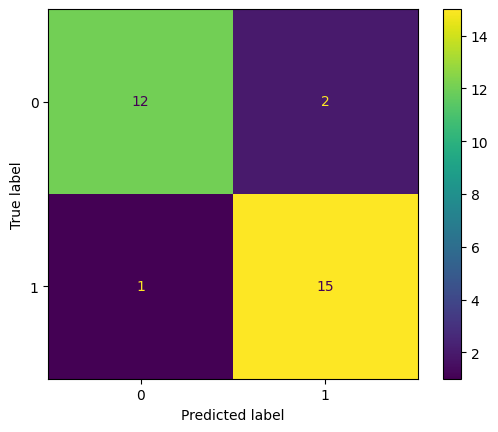

In [ ]:
# model evaluation
def show_model_evaluation(model, X, y):
    predictions = model.predict(X)
    accuracy = accuracy_score(y, predictions)
    balanced_accuracy = balanced_accuracy_score(y, predictions)

    print(f'Accuracy:\t\t{accuracy:.3f}')
    print(f'Balanced Accuracy:\t{balanced_accuracy:.3f}')
    print(classification_report(y, predictions))
    ConfusionMatrixDisplay.from_estimator(model, X,y)
    plt.show()

show_model_evaluation(pipeline,X_test, y_test)

# summarize this!

### Introspecting Decision Trees

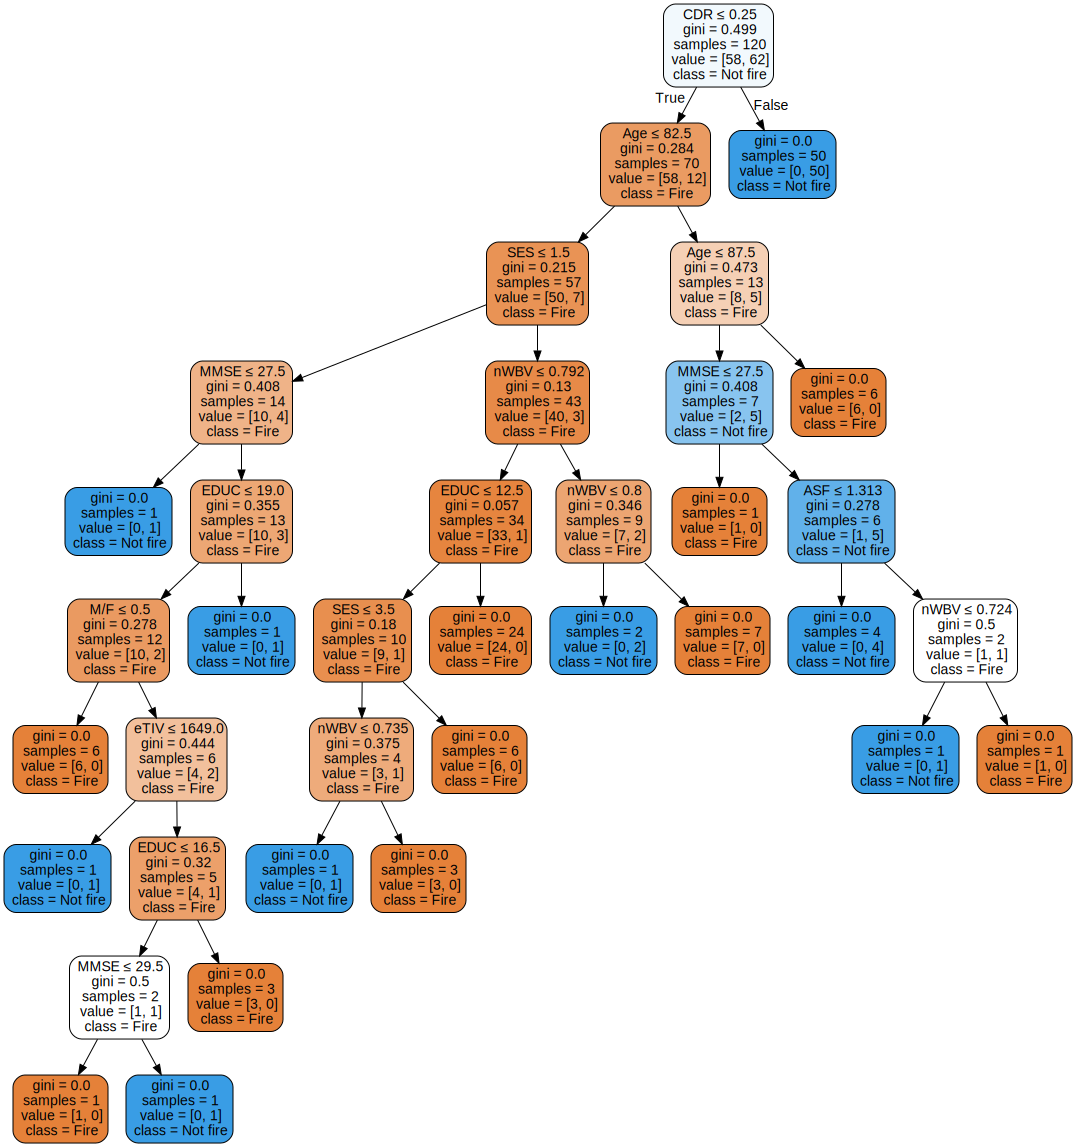

In [ ]:
def show_decision_tree(tree, feature_names=None):
    dot_data = export_graphviz(tree, out_file=None,
                               feature_names=feature_names,
                               class_names=['Fire', 'Not fire'],
                               filled=True, rounded=True,
                               special_characters=True)
    graph = graphviz.Source(dot_data)
    return graph

graph = show_decision_tree(pipeline[-1], feature_names=numeric_features)
graph

In [ ]:
# render on PDF file
graph.render(filename='Capstone-3')

'Capstone-3.pdf'

In [ ]:
# to see how important different features are for decision tree

def show_feature_importances(pipeline, feature_names):
    feature_importances = pipeline[-1].feature_importances_
    top = sorted(zip(feature_importances, feature_names), reverse=True)[:10]
    for importance, name in top:
        print(f'{name.ljust(20)}{importance:.3f}')

show_feature_importances(pipeline, numeric_features)

CDR                 0.668
nWBV                0.102
Age                 0.079
MMSE                0.055
EDUC                0.034
SES                 0.021
eTIV                0.018
M/F                 0.011
ASF                 0.011
MR Delay            0.000


### Optimizing the Decision Tree

Looking at my tree, it is **overfitting**.I can tell becasue decision of the tree go very deep and some leaf nodes contain only 1 or 2 samples. It has developed rules very specific to the training data.

My tree is probably not biased as looking at its evaluation scores, I can see that the accuracy and balanced accuracy are both high. Pretty much close within range of each other.

I will not be using PCS for this as my dataset contains only 12 features.

In [ ]:
clf = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
pipeline = make_pipeline(pipe, clf)
pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(strategy='median'))])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=1))])

Accuracy:		0.967
Balanced Accuracy:	0.969
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.94      0.97        16

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



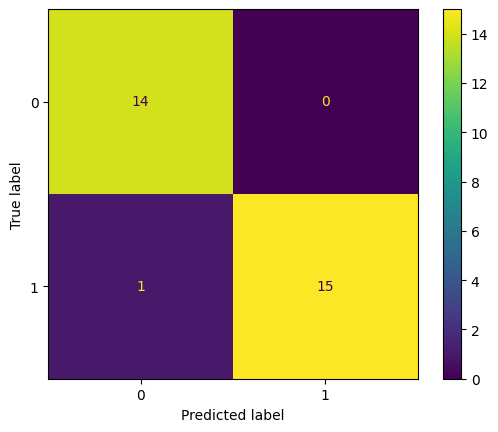

In [ ]:
# retrain model
pipeline.fit(X_train, y_train)
show_model_evaluation(pipeline, X_test, y_test)

Changing the hyperparameters does not change the accuracy and the balanced accuracy of the model. This is as long as the minimum number of samples in each leaf does not go lower than 8. I also tried changing the maximum depth of the tree till 15 and it still did not affect both accuracies.

### Automating Hyper-Parameter Selection

In [ ]:
# parameters that I want to search through
list(pipeline.get_params().keys())

['memory',
 'steps',
 'verbose',
 'pipeline',
 'decisiontreeclassifier',
 'pipeline__memory',
 'pipeline__steps',
 'pipeline__verbose',
 'pipeline__simpleimputer',
 'pipeline__simpleimputer__add_indicator',
 'pipeline__simpleimputer__copy',
 'pipeline__simpleimputer__fill_value',
 'pipeline__simpleimputer__keep_empty_features',
 'pipeline__simpleimputer__missing_values',
 'pipeline__simpleimputer__strategy',
 'pipeline__simpleimputer__verbose',
 'decisiontreeclassifier__ccp_alpha',
 'decisiontreeclassifier__class_weight',
 'decisiontreeclassifier__criterion',
 'decisiontreeclassifier__max_depth',
 'decisiontreeclassifier__max_features',
 'decisiontreeclassifier__max_leaf_nodes',
 'decisiontreeclassifier__min_impurity_decrease',
 'decisiontreeclassifier__min_samples_leaf',
 'decisiontreeclassifier__min_samples_split',
 'decisiontreeclassifier__min_weight_fraction_leaf',
 'decisiontreeclassifier__random_state',
 'decisiontreeclassifier__splitter']

In [ ]:
param_grid = {
    'decisiontreeclassifier__max_depth': list(range(1, 15)), # list(range(1, 15))
    'decisiontreeclassifier__min_samples_leaf': list(range(1, 15)), # list(range(1, 15))
}

In [ ]:
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring= 'balanced_accuracy', n_jobs=-1)
grid_search.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('simpleimputer',
                                                         SimpleImputer(strategy='median'))])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(max_depth=1))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [1, 2, 3, 4, 5, 6,
                                                               7, 8, 9, 10, 11,
                                                               12, 13, 14],
                         'decisiontreeclassifier__min_samples_leaf': [1, 2, 3,
                                                                      4, 5, 6,
                                                                      7, 8, 9,
                                                                      10, 11,
                                                                      12, 13,
                                                                      14]},
             scoring='balanced_accuracy')

In [ ]:
# view the best balanced accuracy
grid_search.best_score_

0.9025641025641026

In [ ]:
# view the parameters that gave the best score
grid_search.best_params_

{'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__min_samples_leaf': 1}

In [ ]:
# summary of the cross validation results in a dataframe
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeclassifier__max_depth,param_decisiontreeclassifier__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008217,0.000770,0.003652,0.000129,1,1,"{'decisiontreeclassifier__max_depth': 1, 'deci...",0.875,0.916667,0.875,0.884615,0.961538,0.902564,0.033222,1
1,0.008212,0.001562,0.003581,0.000416,1,2,"{'decisiontreeclassifier__max_depth': 1, 'deci...",0.875,0.916667,0.875,0.884615,0.961538,0.902564,0.033222,1
2,0.009152,0.001517,0.005810,0.004006,1,3,"{'decisiontreeclassifier__max_depth': 1, 'deci...",0.875,0.916667,0.875,0.884615,0.961538,0.902564,0.033222,1
3,0.008083,0.001411,0.005388,0.002826,1,4,"{'decisiontreeclassifier__max_depth': 1, 'deci...",0.875,0.916667,0.875,0.884615,0.961538,0.902564,0.033222,1
4,0.007964,0.000846,0.003684,0.000151,1,5,"{'decisiontreeclassifier__max_depth': 1, 'deci...",0.875,0.916667,0.875,0.884615,0.961538,0.902564,0.033222,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,0.013735,0.005408,0.003526,0.000703,14,10,"{'decisiontreeclassifier__max_depth': 14, 'dec...",0.875,0.916667,0.875,0.884615,0.961538,0.902564,0.033222,1
192,0.011915,0.003378,0.007131,0.003508,14,11,"{'decisiontreeclassifier__max_depth': 14, 'dec...",0.875,0.916667,0.875,0.884615,0.961538,0.902564,0.033222,1
193,0.014042,0.004900,0.009391,0.004226,14,12,"{'decisiontreeclassifier__max_depth': 14, 'dec...",0.875,0.916667,0.875,0.884615,0.961538,0.902564,0.033222,1
194,0.012370,0.005773,0.009487,0.006263,14,13,"{'decisiontreeclassifier__max_depth': 14, 'dec...",0.875,0.916667,0.875,0.884615,0.961538,0.902564,0.033222,1


In [ ]:
best_pipeline = grid_search.best_estimator_
best_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(strategy='median'))])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=1))])

Accuracy:		0.967
Balanced Accuracy:	0.969
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.94      0.97        16

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



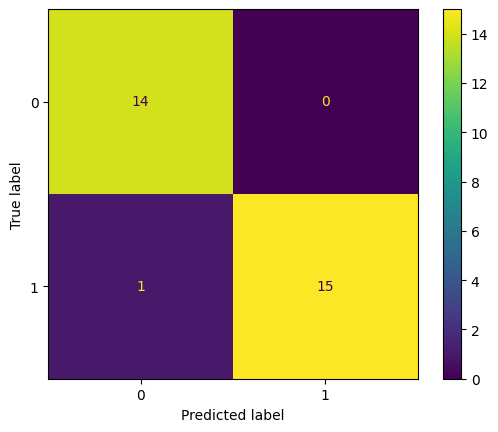

In [ ]:
# test the model
show_model_evaluation(best_pipeline, X_test, y_test)

### Stabilizing the Model

Since using decision tress tends to be unstable, I want to make sure that my model is good. I changed the random seed to 10 from 5.

The model performedvery well! It gave me basically the same results as before with a slightly lower balanced accuracy of 0.969 instead of 0.974.

I am pretty confident with the model to classify whether a data entry is 'Demented' or 'Nondemented'.

However, I also want to try Random Forest Classifier for fun!

In [ ]:
clf = RandomForestClassifier()
clf

RandomForestClassifier()

In [ ]:
best_pipeline.set_params(decisiontreeclassifier=clf)
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(strategy='median'))])),
                ('decisiontreeclassifier', RandomForestClassifier())])

Accuracy:		0.967
Balanced Accuracy:	0.969
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.94      0.97        16

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



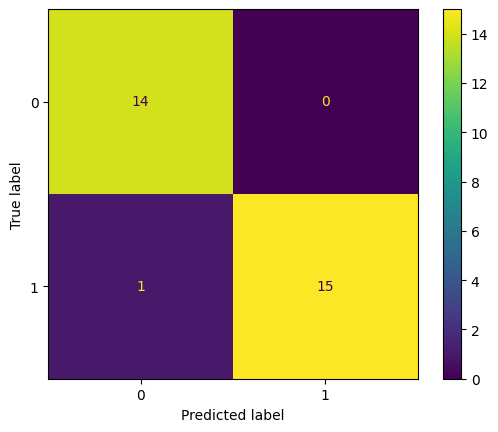

In [ ]:
show_model_evaluation(best_pipeline, X_test, y_test)

In [ ]:
# finding the best parameters fo rthis model
clf = RandomForestClassifier(n_jobs=-1)
pipeline.set_params(decisiontreeclassifier=clf)

param_grid = {
    'decisiontreeclassifier__max_depth': list(range(1, 15)),
    'decisiontreeclassifier__min_samples_leaf': list(range(1, 15))
}

grid_search_challenge = GridSearchCV(pipeline, param_grid=param_grid, scoring='balanced_accuracy', n_jobs=-1)
grid_search_challenge.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('simpleimputer',
                                                         SimpleImputer(strategy='median'))])),
                                       ('decisiontreeclassifier',
                                        RandomForestClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [1, 2, 3, 4, 5, 6,
                                                               7, 8, 9, 10, 11,
                                                               12, 13, 14],
                         'decisiontreeclassifier__min_samples_leaf': [1, 2, 3,
                                                                      4, 5, 6,
                                                                      7, 8, 9,
                                                                      10, 11,
                                                                      12, 13,
                                                                      14]},
             scoring='balanced_accuracy')

In [ ]:
grid_search_challenge.best_params_

{'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__min_samples_leaf': 8}

In [ ]:
best = grid_search_challenge.best_estimator_
best

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(strategy='median'))])),
                ('decisiontreeclassifier',
                 RandomForestClassifier(max_depth=1, min_samples_leaf=8,
                                        n_jobs=-1))])

In [ ]:
best.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(strategy='median'))])),
                ('decisiontreeclassifier',
                 RandomForestClassifier(max_depth=1, min_samples_leaf=8,
                                        n_jobs=-1))])

Accuracy:		0.967
Balanced Accuracy:	0.969
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.94      0.97        16

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



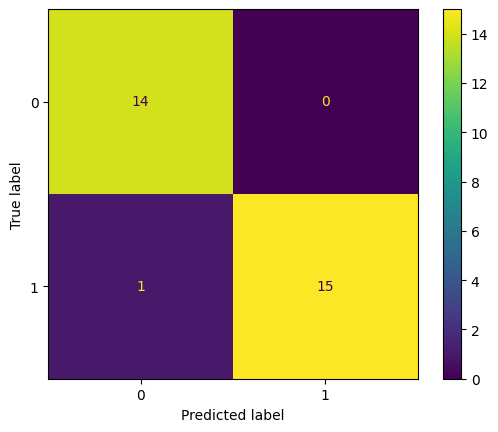

In [ ]:
show_model_evaluation(best, X_test, y_test)